<a href="https://colab.research.google.com/github/vjbarayuga/Week6-Regression_Models/blob/main/SalesPredictionLinRegression_DecisonTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline

from numpy import nan
from numpy import isnan

#pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer

#for missing value and feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

In [4]:
# open filename
filename = '/content/drive/MyDrive/Coding_DOJO-Data_Science_Bootcamp/02_Part_Time_Data_Science/2_Pandas_for_Data_Manipulation/Dataset/sales_predictions.csv'
data = pd.read_csv(filename)
data.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [6]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [7]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [16]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [17]:
#instantiate the selectors to for numeric and categorical data types
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')
#select the numeric columns of each type
numerical_features = num_selector(data)
categorial_features = cat_selector(data)
#check our lists
print('numeric columns are', numerical_features)
print('categorical columns are', categorial_features)

numeric columns are ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
categorical columns are ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [18]:
data['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [19]:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Observations:

Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.

Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.

The lower ‘count’ of Item_Weight and Outlet_Size confirms the findings from the missing value check.

In [20]:
data.apply(lambda x : len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

This tells us that there are 1559 products and 10 outlets/stores (which was also mentioned in problem statement). Another thing that should catch attention is that Item_Type has 16 unique values. Let’s explore further using the frequency of different categories in each nominal variable.

In [22]:
for col in categorial_features:
    print('\n%s column: '%col)
    print(data[col].value_counts())


Item_Identifier column: 
FDG33    10
FDW13    10
FDQ40     9
FDW49     9
FDG09     9
         ..
DRF48     1
FDO33     1
FDC23     1
FDQ60     1
FDY43     1
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Fat_Content column: 
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type column: 
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Identifier column: 
OUT027    935
OUT013    932
OUT046    930
OUT035    930
OUT049    930
OUT045    929
OUT018

In [23]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


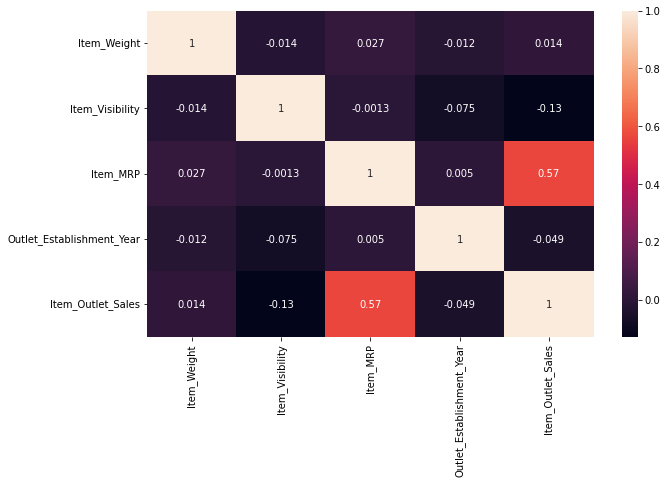

In [26]:
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


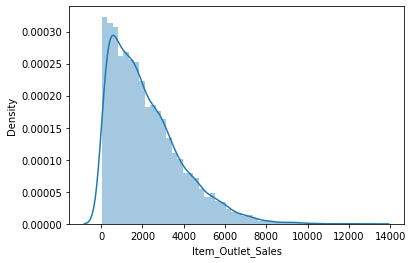

In [27]:
sns.distplot(data['Item_Outlet_Sales'])

In [28]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

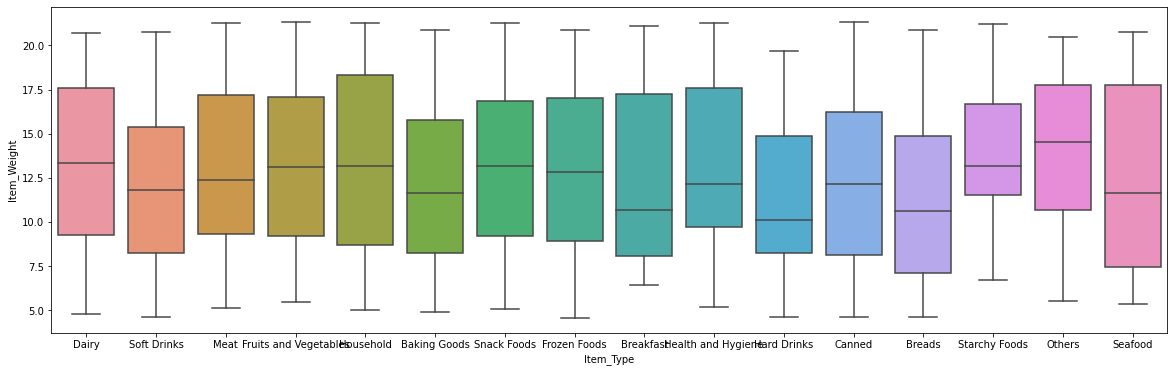

In [29]:
plt.figure(figsize=(20,6))
sns.boxplot(x='Item_Type',y='Item_Weight',data=data)

In [30]:
data['Item_Weight'][data['Item_Weight'].isnull()]=data['Item_Weight'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
data_sale=data[['Item_Weight', 'Item_Visibility', 'Item_MRP','Outlet_Establishment_Year','Item_Outlet_Sales',]]

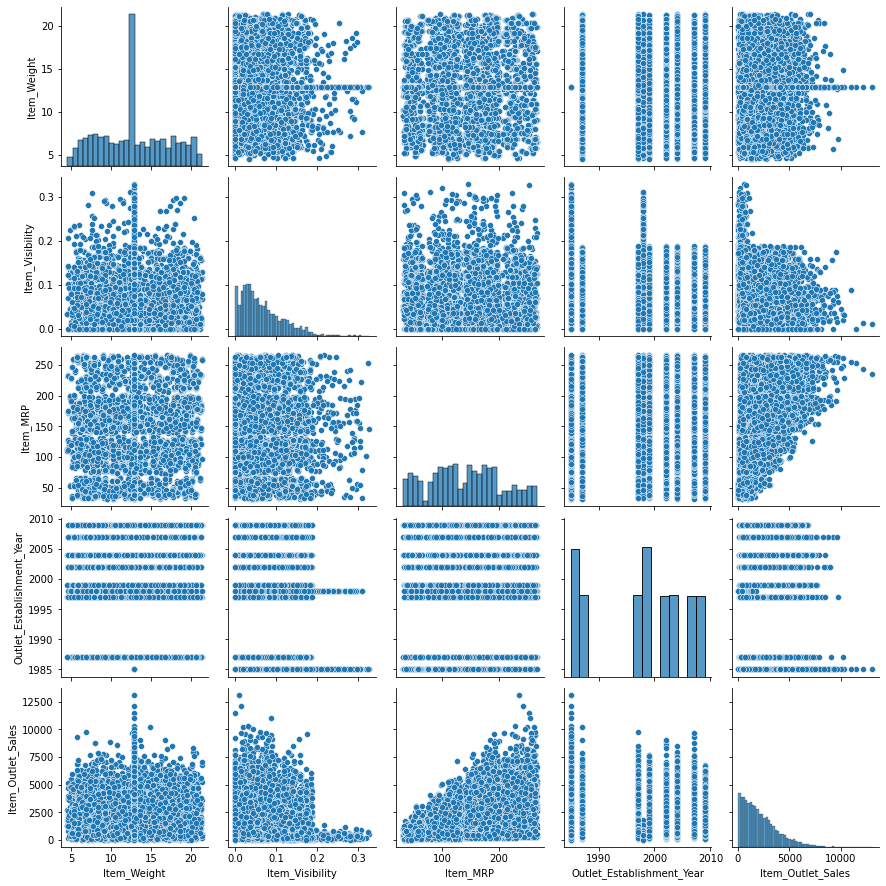

In [36]:
sns.pairplot(data_sale)

In [37]:
X= data_sale.drop(['Item_Outlet_Sales'],axis=1)
y=data_sale['Item_Outlet_Sales']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=105)

In [39]:
model= LinearRegression()

In [40]:
model.fit(X_train,y_train)

LinearRegression()

In [41]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(n_jobs=1, normalize=False)

In [48]:
y_train_predict = model.predict(X_train)
r2 = r2_score(y_train, y_train_predict)

In [49]:
print("MODEL PERFORMANCE TRAIN PREDICT")
print("--------------------------------------")
print('R2 score is {}'.format(r2))
print("\n")

MODEL PERFORMANCE TRAIN PREDICT
--------------------------------------
R2 score is 0.347830198030459




In [50]:
y_train_predict = model.predict(X_test)
r2 = r2_score(y_test, y_train_predict)

In [51]:
print("MODEL PERFORMANCE TRAIN PREDICT")
print("--------------------------------------")
print('R2 score is {}'.format(r2))
print("\n")

MODEL PERFORMANCE TRAIN PREDICT
--------------------------------------
R2 score is 0.33048572104393314




In [52]:
print(model.intercept_)

27764.55354274957


In [53]:
print(model.coef_)

[   -5.76906086 -4533.85252827    15.61965466   -13.7182071 ]


In [54]:
cdf = pd.DataFrame(model.coef_,X.columns,columns=['Coeff'])

In [55]:
cdf

,Coeff
Item_Weight,-5.769061
Item_Visibility,-4533.852528
Item_MRP,15.619655
Outlet_Establishment_Year,-13.718207


In [56]:
predictions=model.predict(X_test)

In [57]:
predictions

array([2604.20879243, 1932.53283172, 1688.15766043, ..., 3844.68718048,
       2251.79959129, 1696.52797497])

In [58]:
from sklearn import metrics

In [59]:
metrics.mean_absolute_error(y_test,predictions)

1033.177957795971

In [60]:
metrics.mean_squared_error(y_test,predictions)

1926432.4511107348

In [61]:
np.sqrt(metrics.mean_squared_error(y_test,predictions))

1387.9598161008607

In [62]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=6)
DT_reg=regressor.fit(X_train, y_train)
DT_reg

DecisionTreeRegressor(max_depth=6)

In [63]:
print(DT_reg.score(X_train,y_train))
print(DT_reg.score(X_test,y_test))

0.4503938536042359
0.4170904674642203


In [64]:
y_pred=DT_reg.predict(X_test)

In [65]:
y_pred

array([3641.50824314, 1972.9601286 , 1542.74849062, ..., 3818.46993537,
        419.47524894, 1542.74849062])

In [66]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

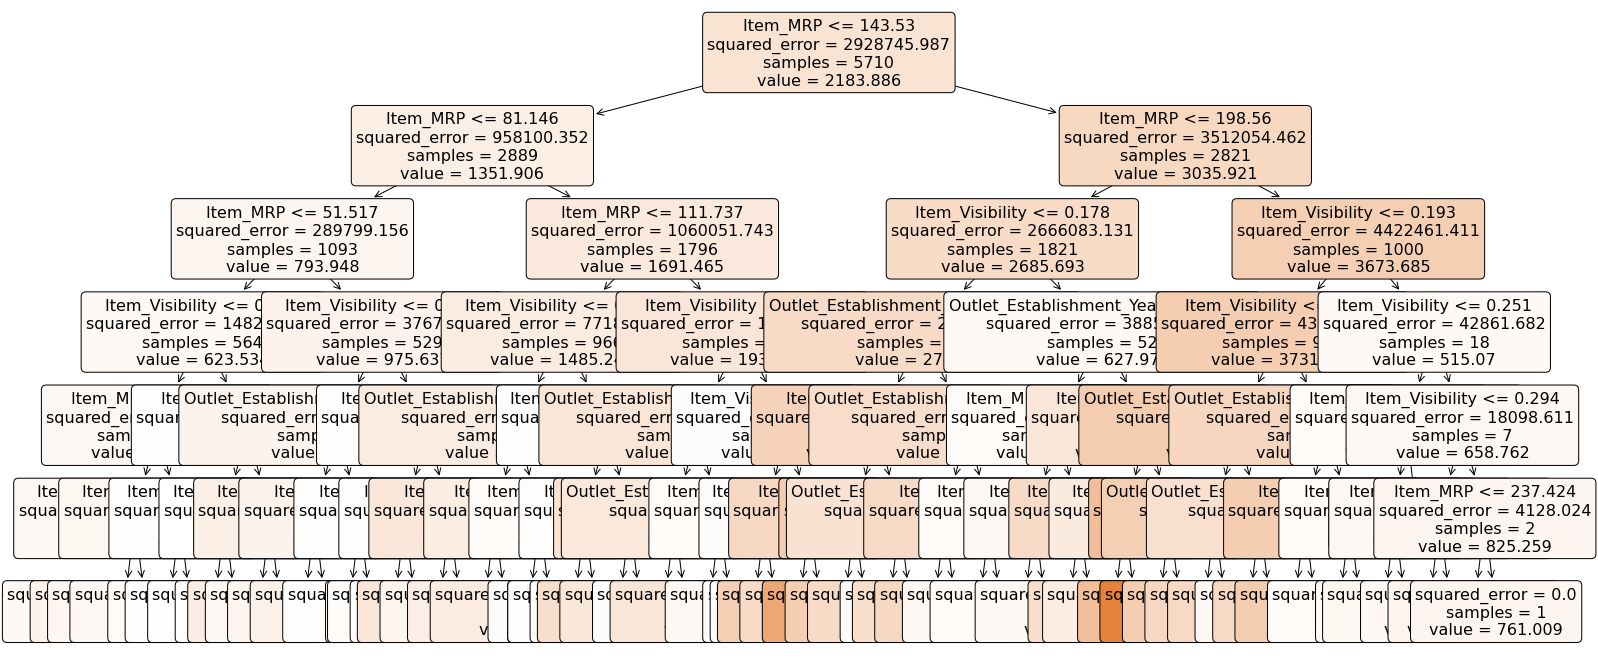

In [67]:
plt.figure(figsize=(25,12))
a = plot_tree(regressor, 
              feature_names=X.columns, 
              class_names=y, 
              filled=True, 
              rounded=True, 
              fontsize=16)